In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
import string
import math

In [ ]:
# Load data
data_fake_ta = pd.read_csv("/content/drive/MyDrive/nlp_dataset/ta_fake.csv")
data_true_ta = pd.read_csv("/content/drive/MyDrive/nlp_dataset/ta_true.csv")

data_fake_ma = pd.read_csv("/content/drive/MyDrive/nlp_dataset/ma_fake.csv")
data_true_ma = pd.read_csv("/content/drive/MyDrive/nlp_dataset/ma_true.csv")

In [ ]:
data_true_ta.head()

,text,label
0,"நாங்கள் எவர் மீதும் வெறுப்பை காட்டவில்லை, யாரை...",1
1,நபார்டு வங்கி மற்றும் ஆசிய-பசிபிக் கிராமப்புற ...,1
2,விவசாயத்தை வியாபாரமாக நடத்த வேண்டும்: மைக்ரோசா...,1
3,எனவே வேலைக்கேற்ற ஆட்களைப் பார்த்துப் பார்த்துப...,1
4,கடந்த 20-ம் தேதி அமெரிக்க அதிப ராக பொறுப்பேற்ற...,1


TAMIL

In [ ]:
data_merge_ta = pd.concat([data_fake_ta, data_true_ta], axis=0)

In [ ]:
data_ta = data_merge_ta

In [ ]:
data_ta.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# Shuffle data
data_ta = data_ta.sample(frac=1)
data_ta.reset_index(inplace=True)
data_ta.drop(['index'], axis=1, inplace=True)

In [ ]:
data_ta.head()

,text,label
0,புகைப்படத்தில் காணப்பட்ட குழந்தை கண்டுபிடிக்கப...,0
1,இன்ஃபோசிஸில் அனைத்தும் நன்றாக இருக்கிறது: நாரா...,1
2,"இந்தப் பாடலை சிவபெருமானை நினைந்து, மனமுருகிப் ...",1
3,இந்த ஒப்பந்தத்தின் மூலம் தற்போது ஆகும் தயாரிப்...,1
4,குஜராத் கலவரத்திற்கு காரணமானவர் பிரதமர் ஃபேஸ்ப...,0


In [ ]:
def wordopt(News):
    News = News.lower()
    News = re.sub('\[.*?\]', '', News)
    #News = re.sub("\\W", " ", News)
    News = re.sub('https?://\S+|www\.\S+', '', News)
    News = re.sub('<.*?>+', '', News)
    News = re.sub('[%s]' % re.escape(string.punctuation), '', News)
    News = re.sub('\n', '', News)
    #News = re.sub('\w*\d\w*', '', News)
    return News

In [ ]:
data_ta['text'] = data_ta['text'].apply(wordopt)

In [ ]:
data_ta.head()

,text,label
0,புகைப்படத்தில் காணப்பட்ட குழந்தை கண்டுபிடிக்கப...,0
1,இன்ஃபோசிஸில் அனைத்தும் நன்றாக இருக்கிறது நாராய...,1
2,இந்தப் பாடலை சிவபெருமானை நினைந்து மனமுருகிப் ப...,1
3,இந்த ஒப்பந்தத்தின் மூலம் தற்போது ஆகும் தயாரிப்...,1
4,குஜராத் கலவரத்திற்கு காரணமானவர் பிரதமர் ஃபேஸ்ப...,0


In [ ]:
x = data_ta['text']
y = data_ta['label']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
# Custom TF-IDF Implementation
def calculate_tf(text):
    words = text.split()
    word_count = len(words)
    tf_dict = {}
    for word in words:
        tf_dict[word] = tf_dict.get(word, 0) + 1 / word_count
    return tf_dict

def calculate_idf(corpus):
    idf_dict = {}
    N = len(corpus)
    for document in corpus:
        words = set(document.split())
        for word in words:
            idf_dict[word] = idf_dict.get(word, 0) + 1
    for word, val in idf_dict.items():
        idf_dict[word] = math.log(N / val)
    return idf_dict

def transform_tfidf(corpus, idf_dict):
    tfidf_matrix = []
    for document in corpus:
        tfidf = {}
        tf = calculate_tf(document)
        for word, tf_val in tf.items():
            tfidf[word] = tf_val * idf_dict.get(word, 0)
        tfidf_matrix.append(tfidf)
    return tfidf_matrix

In [ ]:
# TF-IDF Implementation
corpus = x_train.tolist()
idf_dict = calculate_idf(corpus)
xv_train_tfidf = transform_tfidf(corpus, idf_dict)
xv_test_tfidf = transform_tfidf(x_test.tolist(), idf_dict)

In [ ]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
xv_train_tfidf_array = vectorizer.fit_transform(xv_train_tfidf)
xv_test_tfidf_array = vectorizer.transform(xv_test_tfidf)

In [ ]:
# Function to create vocabulary
def create_vocabulary(documents):
    vocabulary = set()
    for document in documents:
        vocabulary.update(document.split())
    return list(vocabulary)

# Function to represent documents as Bag of Words (BoW) vectors
def bow_representation(documents, vocabulary):
    bow_matrix = []
    for document in documents:
        word_counts = {}
        for word in document.split():
            word_counts[word] = word_counts.get(word, 0) + 1
        bow_vector = [word_counts.get(word, 0) for word in vocabulary]
        bow_matrix.append(bow_vector)
    return bow_matrix


In [ ]:
# Bag of Words (BoW)
vocabulary = create_vocabulary(x_train)
x_train_bow = bow_representation(x_train, vocabulary)
x_test_bow = bow_representation(x_test, vocabulary)

In [ ]:
# Model Training and Evaluation with Cross-Validation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

TF-IDF

In [ ]:
# Logistic Regression with TF-IDF
LR_tfidf = LogisticRegression()
LR_tfidf_scores = cross_val_score(LR_tfidf, xv_train_tfidf_array, y_train, cv=5)
print("Logistic Regression with TF-IDF Cross-Validation Scores:", LR_tfidf_scores)
LR_tfidf.fit(xv_train_tfidf_array, y_train)
pred_lr_tfidf = LR_tfidf.predict(xv_test_tfidf_array)
prob_lr_tfidf = LR_tfidf.predict_proba(xv_test_tfidf_array)[:, 1]
accuracy_lr_tfidf = accuracy_score(y_test, pred_lr_tfidf)
auc_lr_tfidf = roc_auc_score(y_test, prob_lr_tfidf)
print("Logistic Regression with TF-IDF Accuracy:", accuracy_lr_tfidf)
print("Logistic Regression with TF-IDF AUC:", auc_lr_tfidf)
print(classification_report(y_test, pred_lr_tfidf))

Logistic Regression with TF-IDF Cross-Validation Scores: [0.91542289 0.92238806 0.92039801 0.91542289 0.91633466]
Logistic Regression with TF-IDF Accuracy: 0.933969769291965
Logistic Regression with TF-IDF AUC: 0.9839560372555297
              precision    recall  f1-score   support

           0       0.98      0.87      0.93       591
           1       0.90      0.99      0.94       666

    accuracy                           0.93      1257
   macro avg       0.94      0.93      0.93      1257
weighted avg       0.94      0.93      0.93      1257



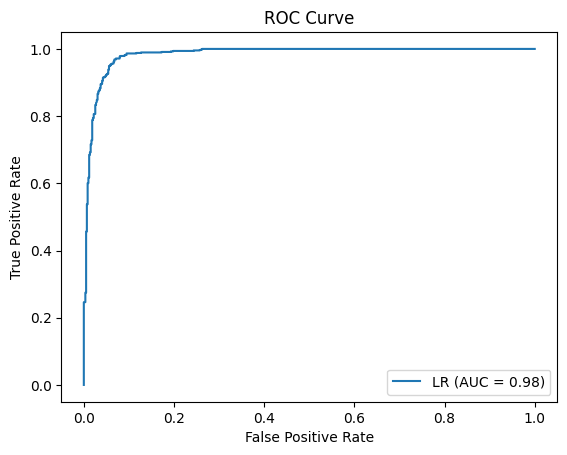

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test, prob_lr_tfidf)
plt.plot(fpr, tpr, label=f"LR (AUC = {auc_lr_tfidf:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Decision Tree with TF-IDF
DT_tfidf = DecisionTreeClassifier()
DT_tfidf_scores = cross_val_score(DT_tfidf, xv_train_tfidf_array, y_train, cv=5)
print("Decision Tree with TF-IDF Cross-Validation Scores:", DT_tfidf_scores)
DT_tfidf.fit(xv_train_tfidf_array, y_train)
pred_dt_tfidf = DT_tfidf.predict(xv_test_tfidf_array)
prob_dt_tfidf = DT_tfidf.predict_proba(xv_test_tfidf_array)[:, 1]
accuracy_dt_tfidf = accuracy_score(y_test, pred_dt_tfidf)
auc_dt_tfidf = roc_auc_score(y_test, prob_dt_tfidf)
print("Decision Tree with TF-IDF Accuracy:", accuracy_dt_tfidf)
print("Decision Tree with TF-IDF AUC:", auc_dt_tfidf)
print(classification_report(y_test, pred_dt_tfidf))

Decision Tree with TF-IDF Cross-Validation Scores: [0.87860697 0.88955224 0.87363184 0.88358209 0.85258964]
Decision Tree with TF-IDF Accuracy: 0.8774860779634049
Decision Tree with TF-IDF AUC: 0.8759050929101689
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       591
           1       0.87      0.90      0.89       666

    accuracy                           0.88      1257
   macro avg       0.88      0.88      0.88      1257
weighted avg       0.88      0.88      0.88      1257



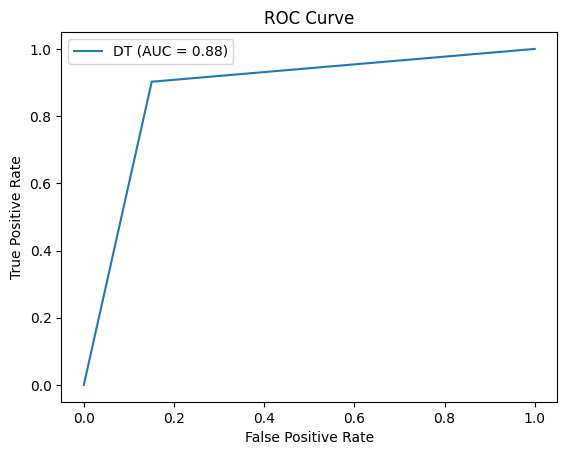

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test, prob_dt_tfidf)
plt.plot(fpr, tpr, label=f"DT (AUC = {auc_dt_tfidf:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Random Forest with TF-IDF
RF_tfidf = RandomForestClassifier(random_state=0)
RF_tfidf_scores = cross_val_score(RF_tfidf, xv_train_tfidf_array, y_train, cv=5)
print("Random Forest with TF-IDF Cross-Validation Scores:", RF_tfidf_scores)
RF_tfidf.fit(xv_train_tfidf_array, y_train)
pred_rf_tfidf = RF_tfidf.predict(xv_test_tfidf_array)
prob_rf_tfidf = RF_tfidf.predict_proba(xv_test_tfidf_array)[:, 1]
accuracy_rf_tfidf = accuracy_score(y_test, pred_rf_tfidf)
auc_rf_tfidf = roc_auc_score(y_test, prob_rf_tfidf)
print("Random Forest with TF-IDF Accuracy:", accuracy_rf_tfidf)
print("Random Forest with TF-IDF AUC:", auc_rf_tfidf)
print(classification_report(y_test, pred_rf_tfidf))

Random Forest with TF-IDF Cross-Validation Scores: [0.91442786 0.91243781 0.90049751 0.89950249 0.89940239]
Random Forest with TF-IDF Accuracy: 0.9172633253778838
Random Forest with TF-IDF AUC: 0.9723543340294609
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       591
           1       0.89      0.97      0.93       666

    accuracy                           0.92      1257
   macro avg       0.92      0.91      0.92      1257
weighted avg       0.92      0.92      0.92      1257



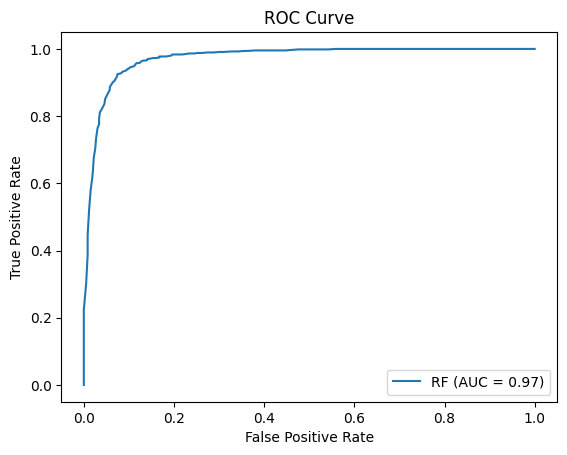

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prob_rf_tfidf)
plt.plot(fpr, tpr, label=f"RF (AUC = {auc_rf_tfidf:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Output label function
def output_label(n):
    return "Fake News" if n == 0 else "Not A Fake News"

In [ ]:
def manual_testing_tfidf(news):
    new_x_test = transform_tfidf([wordopt(news)], idf_dict)
    new_x_test_array = vectorizer.transform(new_x_test)
    # Reshape the input data to 2D array
    new_x_test_array_2d = new_x_test_array.reshape(1, -1)
    pred_LR = LR_tfidf.predict(new_x_test_array_2d)
    pred_DT = DT_tfidf.predict(new_x_test_array_2d)
    pred_RF = RF_tfidf.predict(new_x_test_array_2d)

    print("\nManual Testing with TF-IDF:")
    print("LR Prediction:", output_label(pred_LR[0]))
    print("DT Prediction:", output_label(pred_DT[0]))
    print("RF Prediction:", output_label(pred_RF[0]))

In [ ]:
# Manual Testing
news = input("Enter news for manual testing: ")
manual_testing_tfidf(news)

Enter news for manual testing: பெற்றோர் அனுமதி இன்றி திருமணம் செய்தால் சொத்துரிமை இல்லை என்று உச்ச நீதிமன்றம் சொன்னதா

Manual Testing with TF-IDF:
LR Prediction: Fake News
DT Prediction: Fake News
RF Prediction: Fake News


BOW

In [ ]:
LR_bow = LogisticRegression()
LR_bow_scores = cross_val_score(LR_bow, x_train_bow, y_train, cv=5)
print("Logistic Regression with BoW Cross-Validation Scores:", LR_bow_scores)
LR_bow.fit(x_train_bow, y_train)
pred_lr_bow = LR_bow.predict(x_test_bow)
prob_lr_bow = LR_bow.predict_proba(x_test_bow)[:, 1]
auc_lr_bow = roc_auc_score(y_test, prob_lr_bow)
print("bag of words logistic regression Accuracy:", accuracy_score(y_test, pred_lr_bow))
print("Logistic Regression with BoW AUC:", auc_lr_bow)
print(classification_report(y_test, pred_lr_bow))

Logistic Regression with BoW Cross-Validation Scores: [0.92338308 0.90845771 0.92835821 0.92039801 0.91733068]
bag of words logistic regression Accuracy: 0.9252187748607796
Logistic Regression with BoW AUC: 0.9815170500449689
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       591
           1       0.94      0.91      0.93       666

    accuracy                           0.93      1257
   macro avg       0.92      0.93      0.93      1257
weighted avg       0.93      0.93      0.93      1257



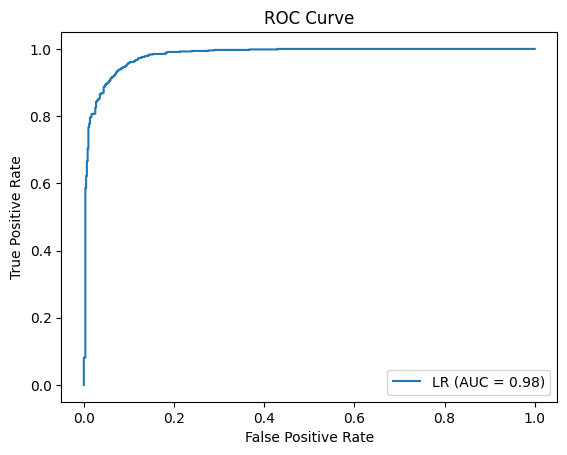

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test, prob_lr_bow)
plt.plot(fpr, tpr, label=f"LR (AUC = {auc_lr_bow:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
DT_bow = DecisionTreeClassifier()
DT_bow_scores = cross_val_score(DT_bow, x_train_bow, y_train, cv=5)
print("Decision Tree with BoW Cross-Validation Scores:", DT_bow_scores)
DT_bow.fit(x_train_bow, y_train)
pred_dt_bow = DT_bow.predict(x_test_bow)
prob_dt_bow = DT_bow.predict_proba(x_test_bow)[:, 1]
auc_dt_bow = roc_auc_score(y_test, prob_dt_bow)
print("bag of words decision tree classifier Accuracy:", accuracy_score(y_test, pred_dt_bow))
print("Decision Tree with BoW AUC:", auc_dt_bow)
print(classification_report(y_test, pred_dt_bow))

Decision Tree with BoW Cross-Validation Scores: [0.84975124 0.85074627 0.83681592 0.86368159 0.85657371]
bag of words decision tree classifier Accuracy: 0.8711217183770883
Decision Tree with BoW AUC: 0.8693274492766879
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       591
           1       0.86      0.90      0.88       666

    accuracy                           0.87      1257
   macro avg       0.87      0.87      0.87      1257
weighted avg       0.87      0.87      0.87      1257



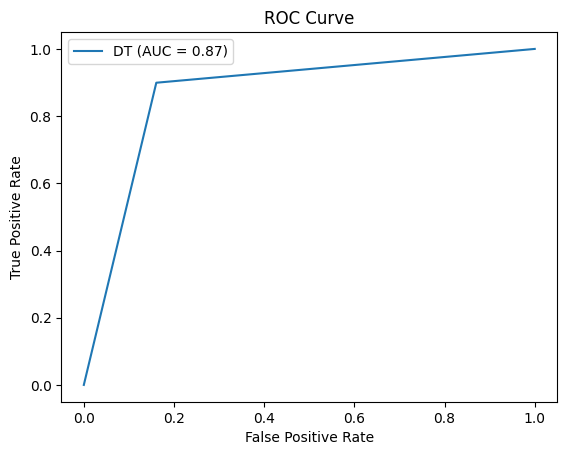

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prob_dt_bow)
plt.plot(fpr, tpr, label=f"DT (AUC = {auc_dt_bow:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
RF_bow = RandomForestClassifier(random_state=0)
RF_bow_scores = cross_val_score(RF_bow, x_train_bow, y_train, cv=5)
print("Random Forest with BoW Cross-Validation Scores:", RF_bow_scores)
RF_bow.fit(x_train_bow, y_train)
pred_rf_bow = RF_bow.predict(x_test_bow)
prob_rf_bow = RF_bow.predict_proba(x_test_bow)[:, 1]
auc_rf_bow = roc_auc_score(y_test, prob_rf_bow)
print("bag of words Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, pred_rf_bow))
print("Random Forest with BoW AUC:", auc_rf_bow)
print(classification_report(y_test, pred_rf_bow))

Random Forest with BoW Cross-Validation Scores: [0.91144279 0.87064677 0.89353234 0.88557214 0.90836653]
bag of words Gradient Boosting Classifier Accuracy: 0.8973747016706444
Random Forest with BoW AUC: 0.9747488605356627
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       591
           1       0.95      0.85      0.90       666

    accuracy                           0.90      1257
   macro avg       0.90      0.90      0.90      1257
weighted avg       0.90      0.90      0.90      1257



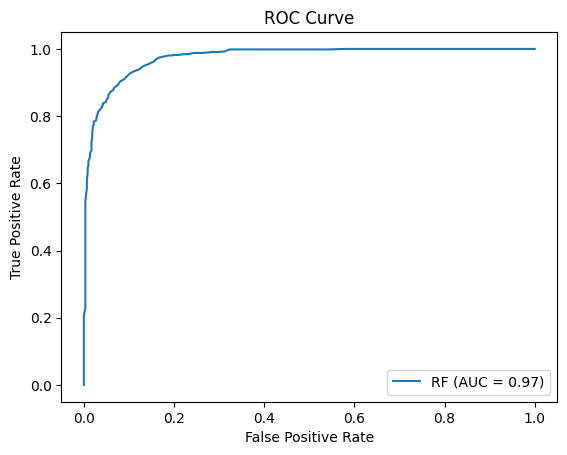

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prob_rf_bow)
plt.plot(fpr, tpr, label=f"RF (AUC = {auc_rf_bow:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
def manual_testing_bow(news):
    news = wordopt(news)
    news_bow = bow_representation([news], vocabulary)[0]
    pred_lr = LR_bow.predict([news_bow])
    pred_dt = DT_bow.predict([news_bow])
    pred_rf = RF_bow.predict([news_bow])

    print("\n\nBag of Words (BoW) Results:")
    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nRF Prediction: {}".format(output_label(pred_lr[0]), output_label(pred_dt[0]), output_label(pred_rf[0])))

In [ ]:
# Manual Testing
news = input("Enter news for manual testing: ")
manual_testing_bow(news)

Enter news for manual testing:  பெற்றோர் அனுமதி இன்றி திருமணம் செய்தால் சொத்துரிமை இல்லை என்று உச்ச நீதிமன்றம் சொன்னதா


Bag of Words (BoW) Results:


LR Prediction: Fake News 
DT Prediction: Fake News 
RF Prediction: Fake News


In [ ]:
import xgboost as xgb
# Define XGBoost parameters
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train XGBoost model
# Train XGBoost model with correct parameter passing
xgb_model_tfidf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss')
xgb_model_tfidf.fit(xv_train_tfidf_array, y_train)


# Evaluate XGBoost model
y_pred_tfidf = xgb_model_tfidf.predict(xv_test_tfidf_array)
prob_xgb_tfidf = xgb_model_tfidf.predict_proba(xv_test_tfidf_array)[:, 1]
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
auc_tfidf = roc_auc_score(y_test, prob_xgb_tfidf)
print("XGBoost with TF-IDF Accuracy:", accuracy_tfidf)
print("XGBoost with TF-IDF AUC:", auc_tfidf)
print(classification_report(y_test, y_pred_tfidf))

XGBoost with TF-IDF Accuracy: 0.8162291169451074
XGBoost with TF-IDF AUC: 0.9201422234417158
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       591
           1       0.76      0.96      0.85       666

    accuracy                           0.82      1257
   macro avg       0.84      0.81      0.81      1257
weighted avg       0.84      0.82      0.81      1257



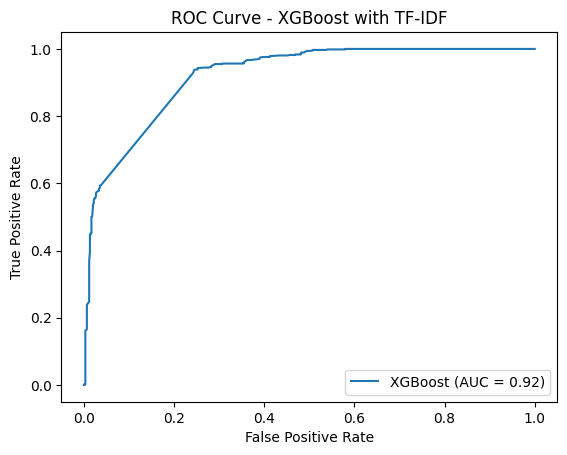

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test, prob_xgb_tfidf)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_tfidf:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost with TF-IDF')
plt.legend()
plt.show()

In [ ]:
# Define XGBoost parameters
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train XGBoost model
# Train XGBoost model with correct parameter passing
xgb_model_bow = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss')
xgb_model_bow.fit(x_train_bow, y_train)


# Evaluate XGBoost model
y_pred_bow = xgb_model_bow.predict(x_test_bow)
prob_xgb_bow = xgb_model_bow.predict_proba(x_test_bow)[:, 1]
accuracy_bow = accuracy_score(y_test, y_pred_bow)
auc_bow = roc_auc_score(y_test, prob_xgb_bow)
print("XGBoost with BoW Accuracy:", accuracy_bow)
print("XGBoost with BoW AUC:", auc_bow)
print(classification_report(y_test, y_pred_bow))

XGBoost with BoW Accuracy: 0.8011137629276054
XGBoost with BoW AUC: 0.9084846267587383
              precision    recall  f1-score   support

           0       0.97      0.59      0.74       591
           1       0.73      0.98      0.84       666

    accuracy                           0.80      1257
   macro avg       0.85      0.79      0.79      1257
weighted avg       0.85      0.80      0.79      1257



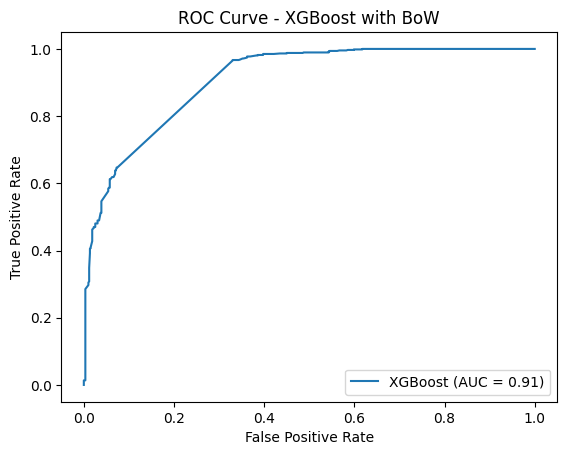

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test, prob_xgb_bow)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_bow:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost with BoW')
plt.legend()
plt.show()

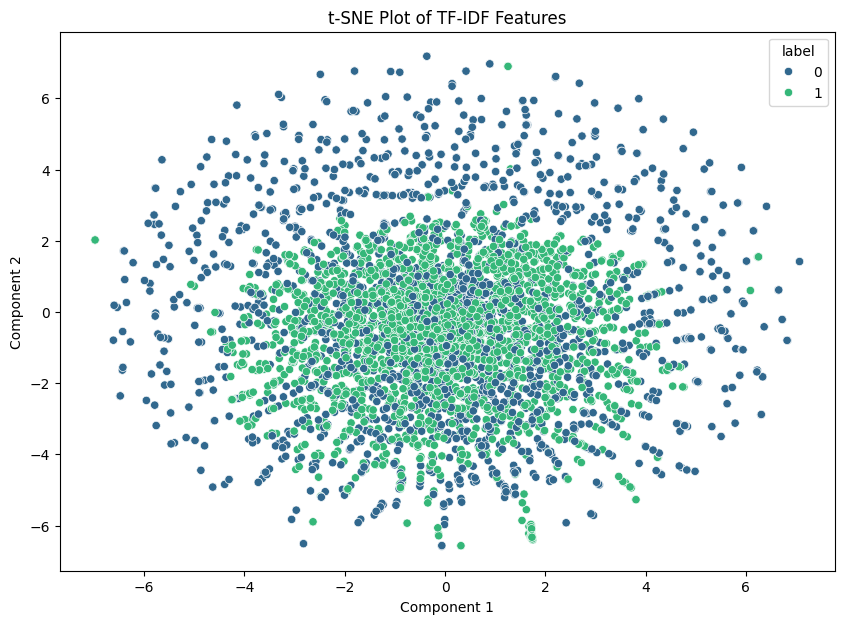

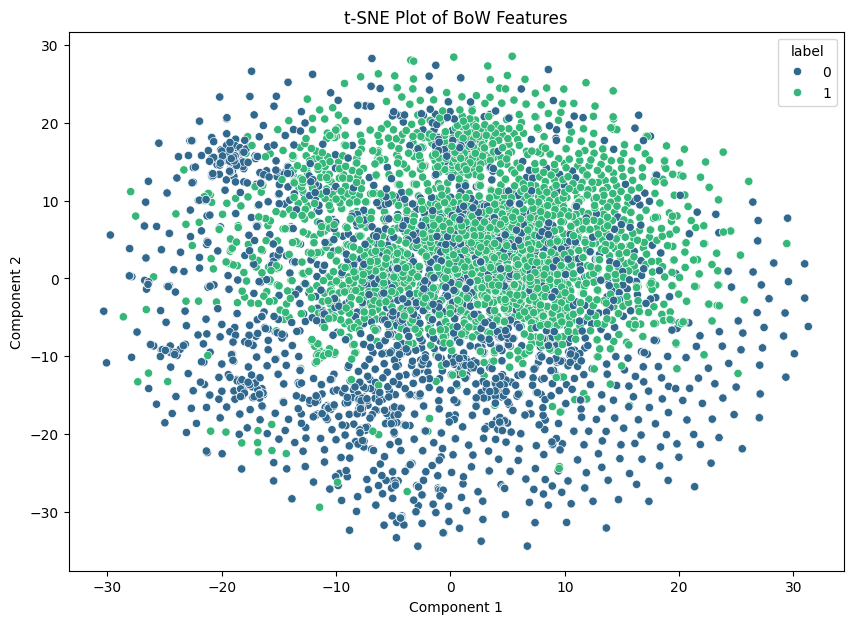

In [ ]:
# Additional imports for t-SNE and visualization
from sklearn.manifold import TSNE

# t-SNE Plot Function
def plot_tsne(X, y, title):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(X)
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['label'] = y.reset_index(drop=True)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='Component 1', y='Component 2', hue='label', palette='viridis', data=df_tsne)
    plt.title(title)
    plt.show()

# Applying t-SNE to TF-IDF features
plot_tsne(xv_train_tfidf_array, y_train, "t-SNE Plot of TF-IDF Features")

# Convert BoW to NumPy arrays
x_train_bow_array = np.array(x_train_bow)
x_test_bow_array = np.array(x_test_bow)
# Applying t-SNE to BoW features
plot_tsne(x_train_bow_array, y_train, "t-SNE Plot of BoW Features")

MALAYALAM

In [ ]:
data_merge_ma = pd.concat([data_fake_ma, data_true_ma], axis=0)

In [ ]:
data_ma = data_merge_ma

In [ ]:
data_ma.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# Shuffle data
data_ma = data_ma.sample(frac=1)
data_ma.reset_index(inplace=True)
data_ma.drop(['index'], axis=1, inplace=True)

In [ ]:
data_ma.head()

,text,label
0,ഈ ദൃശ്യങ്ങള്‍ അല്‍-അക്സാ പള്ളിയുടെതല്ല സത്യാവ...,0
1,പാകിസ്ഥാനിലെ ചിത്രം പാലസ്തിന്‍റെ പേരില്‍ തെറ്...,0
2,ഗ്രാമവാസീസ് ഉടന്‍ തീയറ്ററുകളിലെത്തുന്നു,1
3,അബ്ദുള്ളക്കുട്ടിയെ ഉപാധ്യക്ഷൻ ആക്കിയതിൽ കുമ്മന...,0
4,"ഖത്തറിന് എതിരായ ഇന്ത്യന്‍ ടീം പ്രഖ്യാപിച്ചു, മ...",1


In [ ]:
x_ma = data_ma['text']
y_ma = data_ma['label']

In [ ]:
x_train_ma, x_test_ma, y_train_ma, y_test_ma = train_test_split(x_ma, y_ma, test_size=0.2)

In [ ]:
# TF-IDF Implementation
corpus_ma = x_train_ma.tolist()
idf_dict_ma = calculate_idf(corpus_ma)
xv_train_tfidf_ma = transform_tfidf(corpus_ma, idf_dict_ma)
xv_test_tfidf_ma = transform_tfidf(x_test_ma.tolist(), idf_dict_ma)

In [ ]:
from sklearn.feature_extraction import DictVectorizer

vectorizer_ma = DictVectorizer(sparse=False)
xv_train_tfidf_array_ma = vectorizer_ma.fit_transform(xv_train_tfidf_ma)
xv_test_tfidf_array_ma = vectorizer_ma.transform(xv_test_tfidf_ma)

In [ ]:
# Bag of Words (BoW)
vocabulary_ma = create_vocabulary(x_train_ma)
x_train_bow_ma = bow_representation(x_train_ma, vocabulary_ma)
x_test_bow_ma = bow_representation(x_test_ma, vocabulary_ma)

TF-IDF

In [ ]:
# Logistic Regression with TF-IDF
LR_tfidf_ma = LogisticRegression()
LR_tfidf_scores_ma = cross_val_score(LR_tfidf_ma, xv_train_tfidf_array_ma, y_train_ma, cv=5)
print("Logistic Regression with TF-IDF Cross-Validation Scores:", LR_tfidf_scores_ma)
LR_tfidf_ma.fit(xv_train_tfidf_array_ma, y_train_ma)
pred_lr_tfidf_ma = LR_tfidf_ma.predict(xv_test_tfidf_array_ma)
prob_lr_tfidf_ma = LR_tfidf_ma.predict_proba(xv_test_tfidf_array_ma)[:, 1]
accuracy_lr_tfidf_ma = accuracy_score(y_test_ma, pred_lr_tfidf_ma)
auc_lr_tfidf_ma = roc_auc_score(y_test_ma, prob_lr_tfidf_ma)
print("Logistic Regression with TF-IDF Accuracy:", accuracy_lr_tfidf_ma)
print("Logistic Regression with TF-IDF AUC:", auc_lr_tfidf_ma)
print(classification_report(y_test_ma, pred_lr_tfidf_ma))

Logistic Regression with TF-IDF Cross-Validation Scores: [0.94511278 0.92781955 0.94135338 0.95334838 0.94582393]
Logistic Regression with TF-IDF Accuracy: 0.9284425736620565
Logistic Regression with TF-IDF AUC: 0.9813402453194862
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       797
           1       0.92      0.94      0.93       866

    accuracy                           0.93      1663
   macro avg       0.93      0.93      0.93      1663
weighted avg       0.93      0.93      0.93      1663



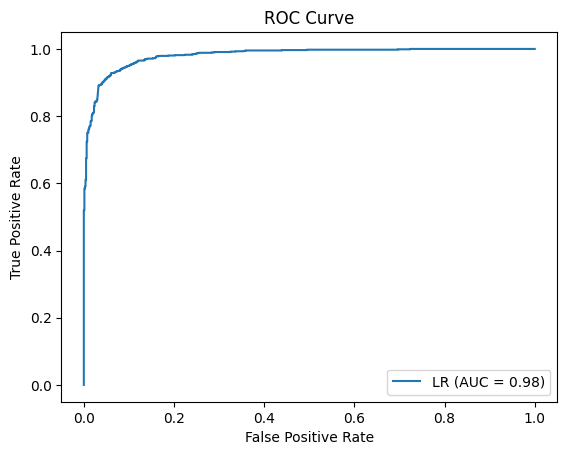

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test_ma, prob_lr_tfidf_ma)
plt.plot(fpr, tpr, label=f"LR (AUC = {auc_lr_tfidf_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Decision Tree with TF-IDF
DT_tfidf_ma = DecisionTreeClassifier()
DT_tfidf_scores_ma = cross_val_score(DT_tfidf_ma, xv_train_tfidf_array_ma, y_train_ma, cv=5)
print("Decision Tree with TF-IDF Cross-Validation Scores:", DT_tfidf_scores_ma)
DT_tfidf_ma.fit(xv_train_tfidf_array_ma, y_train_ma)
pred_dt_tfidf_ma = DT_tfidf_ma.predict(xv_test_tfidf_array_ma)
prob_dt_tfidf_ma = DT_tfidf_ma.predict_proba(xv_test_tfidf_array_ma)[:, 1]
accuracy_dt_tfidf_ma = accuracy_score(y_test_ma, pred_dt_tfidf_ma)
auc_dt_tfidf_ma = roc_auc_score(y_test_ma, prob_dt_tfidf_ma)
print("Decision Tree with TF-IDF Accuracy:", accuracy_dt_tfidf_ma)
print("Decision Tree with TF-IDF AUC:", auc_dt_tfidf_ma)
print(classification_report(y_test_ma, pred_dt_tfidf_ma))

Decision Tree with TF-IDF Cross-Validation Scores: [0.90075188 0.89022556 0.90827068 0.89766742 0.90669676]
Decision Tree with TF-IDF Accuracy: 0.8851473241130488
Decision Tree with TF-IDF AUC: 0.8835746636491926
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       797
           1       0.87      0.92      0.89       866

    accuracy                           0.89      1663
   macro avg       0.89      0.88      0.88      1663
weighted avg       0.89      0.89      0.88      1663



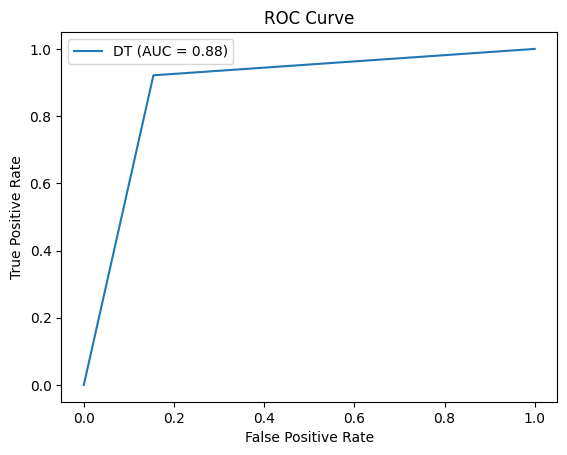

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test_ma, prob_dt_tfidf_ma)
plt.plot(fpr, tpr, label=f"DT (AUC = {auc_dt_tfidf_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Random Forest with TF-IDF
RF_tfidf_ma = RandomForestClassifier(random_state=0)
RF_tfidf_scores_ma = cross_val_score(RF_tfidf_ma, xv_train_tfidf_array_ma, y_train_ma, cv=5)
print("Random Forest with TF-IDF Cross-Validation Scores:", RF_tfidf_scores_ma)
RF_tfidf_ma.fit(xv_train_tfidf_array_ma, y_train_ma)
pred_rf_tfidf_ma = RF_tfidf_ma.predict(xv_test_tfidf_array_ma)
prob_rf_tfidf_ma = RF_tfidf_ma.predict_proba(xv_test_tfidf_array_ma)[:, 1]
accuracy_rf_tfidf_ma = accuracy_score(y_test_ma, pred_rf_tfidf_ma)
auc_rf_tfidf_ma = roc_auc_score(y_test_ma, prob_rf_tfidf_ma)
print("Random Forest with TF-IDF Accuracy:", accuracy_rf_tfidf_ma)
print("Random Forest with TF-IDF AUC:", auc_rf_tfidf_ma)
print(classification_report(y_test_ma, pred_rf_tfidf_ma))

Random Forest with TF-IDF Cross-Validation Scores: [0.91428571 0.90676692 0.91203008 0.92024078 0.917231  ]
Random Forest with TF-IDF Accuracy: 0.8959711365003007
Random Forest with TF-IDF AUC: 0.9692249515359271
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       797
           1       0.87      0.93      0.90       866

    accuracy                           0.90      1663
   macro avg       0.90      0.89      0.90      1663
weighted avg       0.90      0.90      0.90      1663



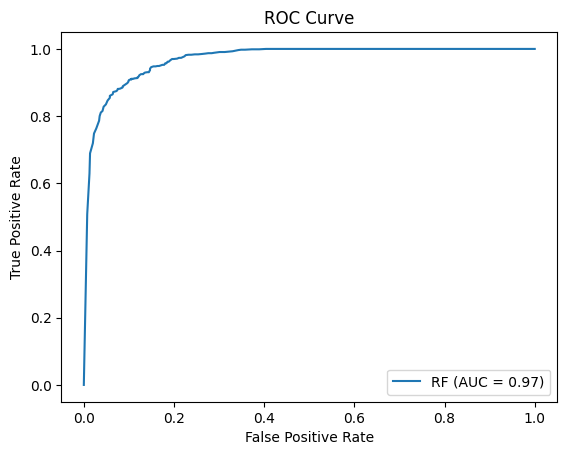

In [ ]:
fpr, tpr, _ = roc_curve(y_test_ma, prob_rf_tfidf_ma)
plt.plot(fpr, tpr, label=f"RF (AUC = {auc_rf_tfidf_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

BOW

In [ ]:
LR_bow_ma = LogisticRegression()
LR_bow_scores_ma = cross_val_score(LR_bow_ma, x_train_bow_ma, y_train_ma, cv=5)
print("Logistic Regression with BoW Cross-Validation Scores:", LR_bow_scores_ma)
LR_bow_ma.fit(x_train_bow_ma, y_train_ma)
pred_lr_bow_ma = LR_bow_ma.predict(x_test_bow_ma)
prob_lr_bow_ma = LR_bow_ma.predict_proba(x_test_bow_ma)[:, 1]
auc_lr_bow_ma = roc_auc_score(y_test_ma, prob_lr_bow_ma)
print("bag of words logistic regression Accuracy:", accuracy_score(y_test_ma, pred_lr_bow_ma))
print("Logistic Regression with BoW AUC:", auc_lr_bow_ma)
print(classification_report(y_test_ma, pred_lr_bow_ma))

Logistic Regression with BoW Cross-Validation Scores: [0.92255639 0.90902256 0.92105263 0.92851768 0.93453725]
bag of words logistic regression Accuracy: 0.9079975947083584
Logistic Regression with BoW AUC: 0.9788453235429628
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       797
           1       0.87      0.97      0.92       866

    accuracy                           0.91      1663
   macro avg       0.92      0.91      0.91      1663
weighted avg       0.91      0.91      0.91      1663



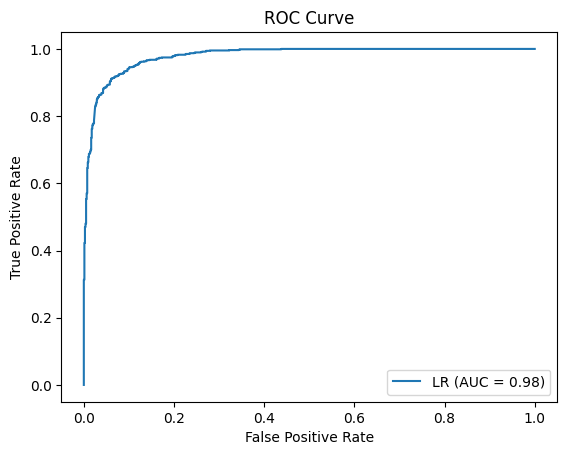

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test_ma, prob_lr_bow_ma)
plt.plot(fpr, tpr, label=f"LR (AUC = {auc_lr_bow_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
DT_bow_ma = DecisionTreeClassifier()
DT_bow_scores_ma = cross_val_score(DT_bow_ma, x_train_bow_ma, y_train_ma, cv=5)
print("Decision Tree with BoW Cross-Validation Scores:", DT_bow_scores_ma)
DT_bow_ma.fit(x_train_bow_ma, y_train_ma)
pred_dt_bow_ma = DT_bow_ma.predict(x_test_bow_ma)
prob_dt_bow_ma = DT_bow_ma.predict_proba(x_test_bow_ma)[:, 1]
auc_dt_bow_ma = roc_auc_score(y_test_ma, prob_dt_bow_ma)
print("bag of words decision tree classifier Accuracy:", accuracy_score(y_test_ma, pred_dt_bow_ma))
print("Decision Tree with BoW AUC:", auc_dt_bow_ma)
print(classification_report(y_test_ma, pred_dt_bow_ma))

Decision Tree with BoW Cross-Validation Scores: [0.90075188 0.89473684 0.90902256 0.91045899 0.91196388]
bag of words decision tree classifier Accuracy: 0.8923631990378833
Decision Tree with BoW AUC: 0.8913028359813503
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       797
           1       0.88      0.92      0.90       866

    accuracy                           0.89      1663
   macro avg       0.89      0.89      0.89      1663
weighted avg       0.89      0.89      0.89      1663



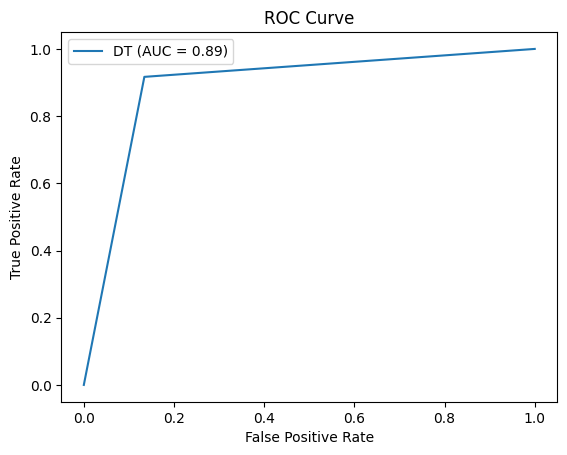

In [ ]:
fpr, tpr, _ = roc_curve(y_test_ma, prob_dt_bow_ma)
plt.plot(fpr, tpr, label=f"DT (AUC = {auc_dt_bow_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
RF_bow_ma = RandomForestClassifier(random_state=0)
RF_bow_scores_ma = cross_val_score(RF_bow_ma, x_train_bow_ma, y_train_ma, cv=5)
print("Random Forest with BoW Cross-Validation Scores:", RF_bow_scores_ma)
RF_bow_ma.fit(x_train_bow_ma, y_train_ma)
pred_rf_bow_ma = RF_bow_ma.predict(x_test_bow_ma)
prob_rf_bow_ma = RF_bow_ma.predict_proba(x_test_bow_ma)[:, 1]
auc_rf_bow_ma = roc_auc_score(y_test_ma, prob_rf_bow_ma)
print("bag of words Random forest Classifier Accuracy:", accuracy_score(y_test_ma, pred_rf_bow_ma))
print("Random Forest with BoW AUC:", auc_rf_bow_ma)
print(classification_report(y_test_ma, pred_rf_bow_ma))

Random Forest with BoW Cross-Validation Scores: [0.92105263 0.90150376 0.91503759 0.92174567 0.92099323]
bag of words Random forest Classifier Accuracy: 0.8989777510523151
Random Forest with BoW AUC: 0.9711787273870548
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       797
           1       0.87      0.95      0.91       866

    accuracy                           0.90      1663
   macro avg       0.90      0.90      0.90      1663
weighted avg       0.90      0.90      0.90      1663



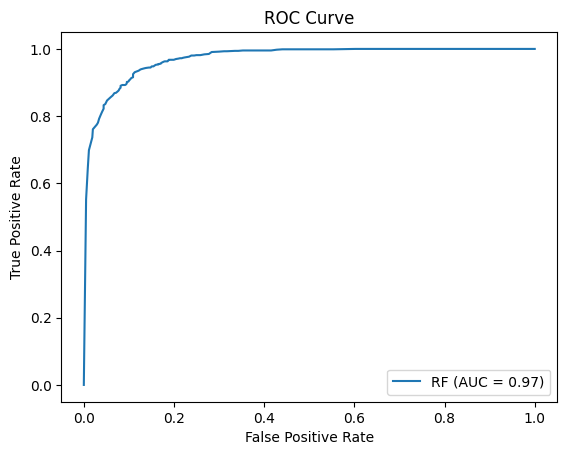

In [ ]:
fpr, tpr, _ = roc_curve(y_test_ma, prob_rf_bow_ma)
plt.plot(fpr, tpr, label=f"RF (AUC = {auc_rf_bow_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
import xgboost as xgb
# Define XGBoost parameters
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train XGBoost model
# Train XGBoost model with correct parameter passing
xgb_model_tfidf_ma = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss')
xgb_model_tfidf_ma.fit(xv_train_tfidf_array_ma, y_train_ma)


# Evaluate XGBoost model
y_pred_tfidf_ma = xgb_model_tfidf_ma.predict(xv_test_tfidf_array_ma)
prob_xgb_tfidf_ma = xgb_model_tfidf_ma.predict_proba(xv_test_tfidf_array_ma)[:, 1]
accuracy_tfidf_ma = accuracy_score(y_test_ma, y_pred_tfidf_ma)
auc_tfidf_ma = roc_auc_score(y_test_ma, prob_xgb_tfidf_ma)
print("XGBoost with TF-IDF Accuracy:", accuracy_tfidf_ma)
print("XGBoost with TF-IDF AUC:", auc_tfidf_ma)
print(classification_report(y_test_ma, y_pred_tfidf_ma))

XGBoost with TF-IDF Accuracy: 0.8165965123271197
XGBoost with TF-IDF AUC: 0.8773293905262518
              precision    recall  f1-score   support

           0       0.92      0.67      0.78       797
           1       0.76      0.95      0.84       866

    accuracy                           0.82      1663
   macro avg       0.84      0.81      0.81      1663
weighted avg       0.84      0.82      0.81      1663



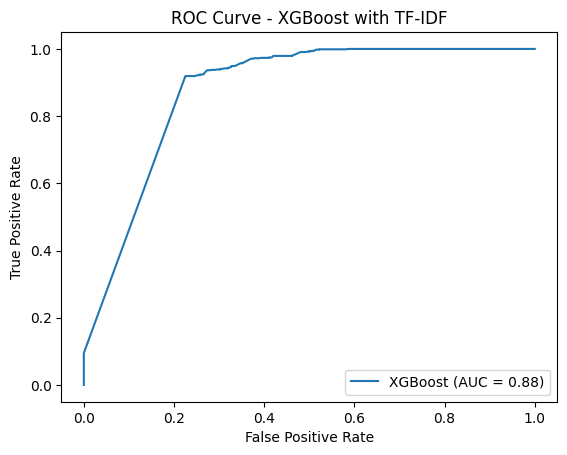

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test_ma, prob_xgb_tfidf_ma)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_tfidf_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost with TF-IDF')
plt.legend()
plt.show()

In [ ]:
# Define XGBoost parameters
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train XGBoost model
# Train XGBoost model with correct parameter passing
xgb_model_bow_ma = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss')
xgb_model_bow_ma.fit(x_train_bow_ma, y_train_ma)


# Evaluate XGBoost model
y_pred_bow_ma = xgb_model_bow_ma.predict(x_test_bow_ma)
prob_xgb_bow_ma = xgb_model_bow_ma.predict_proba(x_test_bow_ma)[:, 1]
accuracy_bow_ma = accuracy_score(y_test_ma, y_pred_bow_ma)
auc_bow_ma = roc_auc_score(y_test_ma, prob_xgb_bow_ma)
print("XGBoost with BoW Accuracy:", accuracy_bow_ma)
print("XGBoost with BoW AUC:", auc_bow_ma)
print(classification_report(y_test_ma, y_pred_bow_ma))

XGBoost with BoW Accuracy: 0.8153938665063138
XGBoost with BoW AUC: 0.8740093479879804
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       797
           1       0.75      0.96      0.84       866

    accuracy                           0.82      1663
   macro avg       0.84      0.81      0.81      1663
weighted avg       0.84      0.82      0.81      1663



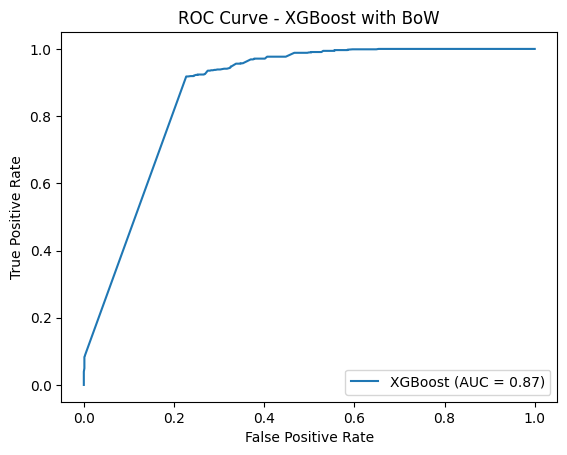

In [ ]:
# Plotting AUC curve
fpr, tpr, _ = roc_curve(y_test_ma, prob_xgb_bow_ma)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_bow_ma:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost with BoW')
plt.legend()
plt.show()

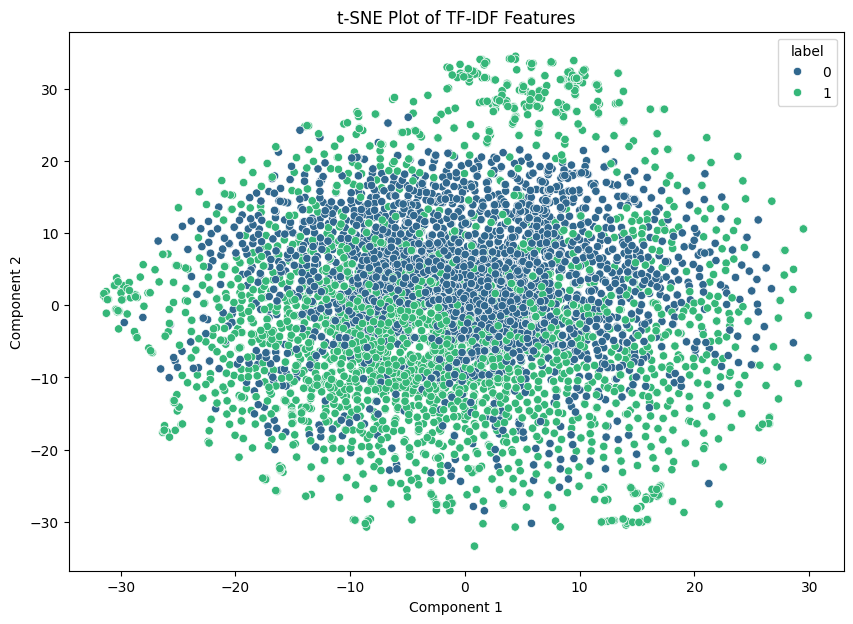

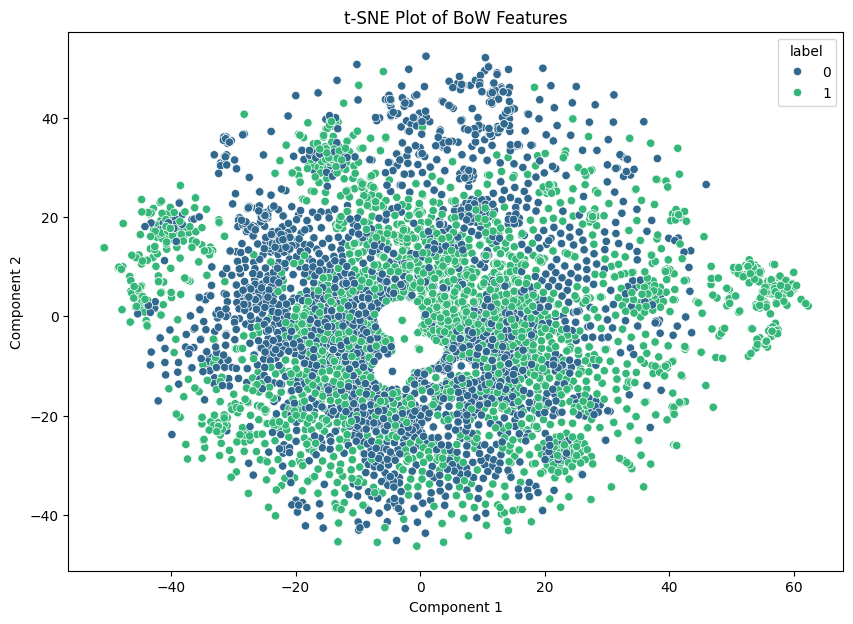

In [ ]:
# Additional imports for t-SNE and visualization
from sklearn.manifold import TSNE

# t-SNE Plot Function
def plot_tsne(X, y, title):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(X)
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['label'] = y.reset_index(drop=True)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='Component 1', y='Component 2', hue='label', palette='viridis', data=df_tsne)
    plt.title(title)
    plt.show()

# Applying t-SNE to TF-IDF features
plot_tsne(xv_train_tfidf_array_ma, y_train_ma, "t-SNE Plot of TF-IDF Features")

# Convert BoW to NumPy arrays
x_train_bow_array = np.array(x_train_bow_ma)
x_test_bow_array = np.array(x_test_bow_ma)
# Applying t-SNE to BoW features
plot_tsne(x_train_bow_array, y_train_ma, "t-SNE Plot of BoW Features")

Column names in the CSV file: Index(['text', 'label'], dtype='object')
Epoch [1/50], Loss: 0.4008
Epoch [2/50], Loss: 0.1803
Epoch [3/50], Loss: 0.1948
Epoch [4/50], Loss: 0.1593
Epoch [5/50], Loss: 0.1693
Epoch [6/50], Loss: 0.0602
Epoch [7/50], Loss: 0.0319
Epoch [8/50], Loss: 0.1653
Epoch [9/50], Loss: 0.0679
Epoch [10/50], Loss: 0.1609
Epoch [11/50], Loss: 0.0870
Epoch [12/50], Loss: 0.0400
Epoch [13/50], Loss: 0.0222
Epoch [14/50], Loss: 0.0519
Epoch [15/50], Loss: 0.1288
Epoch [16/50], Loss: 0.0526
Epoch [17/50], Loss: 0.0233
Epoch [18/50], Loss: 0.0103
Epoch [19/50], Loss: 0.0948
Epoch [20/50], Loss: 0.0570
Epoch [21/50], Loss: 0.0188
Epoch [22/50], Loss: 0.0403
Epoch [23/50], Loss: 0.0318
Epoch [24/50], Loss: 0.0119
Epoch [25/50], Loss: 0.0350
Epoch [26/50], Loss: 0.0315
Epoch [27/50], Loss: 0.0070
Epoch [28/50], Loss: 0.0056
Epoch [29/50], Loss: 0.0311
Epoch [30/50], Loss: 0.0092
Epoch [31/50], Loss: 0.0043
Epoch [32/50], Loss: 0.0375
Epoch [33/50], Loss: 0.0259
Epoch [34/50],

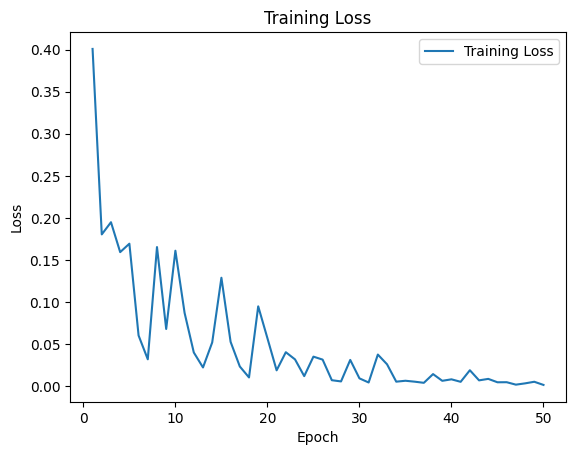

Train Accuracy: 0.9988083889418494
Train F1 Score: 0.9988084183955297
Train Precision: 0.9988112854198712
Train Recall: 0.9988083889418494
Test Accuracy: 0.8679883945841392
Test F1 Score: 0.8679312946295418
Test Precision: 0.8686258967663476
Test Recall: 0.8679883945841392


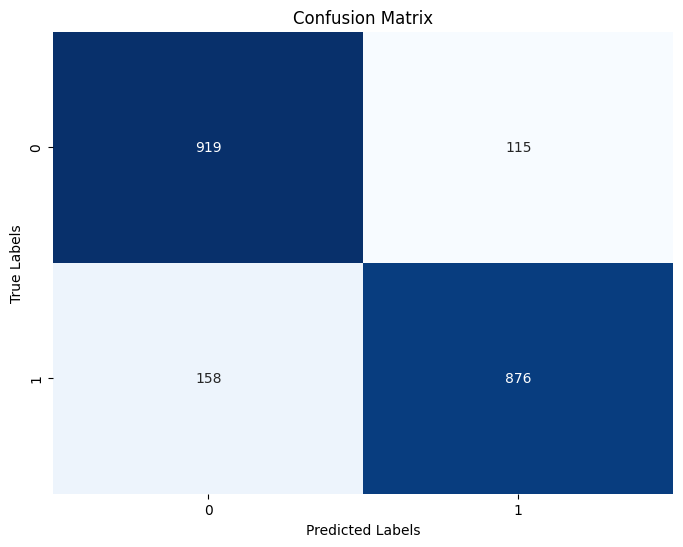

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Load data from CSV
df = pd.read_csv("/content/drive/MyDrive/nlp_dataset/merge.csv")

# Inspect column names
print("Column names in the CSV file:", df.columns)

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise KeyError("CSV file must contain 'text' and 'label' columns")

# Extract 'text' and 'label' columns
texts = df['text'].astype(str).tolist()
labels = df['label'].astype(str).tolist()

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts).toarray().astype(np.float32)
y = np.array(labels).astype(np.uint8)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 100  # Adjust as necessary
output_dim = len(np.unique(y))

model = MLP(input_dim, hidden_dim, output_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
batch_size = 64

def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs, batch_size):
    train_losses = []
    for epoch in range(num_epochs):
        permutation = torch.randperm(X_train_tensor.size()[0])
        for i in range(0, X_train_tensor.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss.item()
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, num_epochs, batch_size)

# Evaluating the model
def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)

    acc = accuracy_score(y_tensor.numpy(), preds.numpy())
    f1 = f1_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    prec = precision_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    recall = recall_score(y_tensor.numpy(), preds.numpy(), average='weighted')

    return acc, f1, prec, recall, preds

train_acc, train_f1, train_prec, train_recall, train_preds = evaluate_model(model, X_train_tensor, y_train_tensor)
test_acc, test_f1, test_prec, test_recall, test_preds = evaluate_model(model, X_test_tensor, y_test_tensor)

print("Train Accuracy:", train_acc)
print("Train F1 Score:", train_f1)
print("Train Precision:", train_prec)
print("Train Recall:", train_recall)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_prec)
print("Test Recall:", test_recall)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.show()

plot_confusion_matrix(y_test_tensor.numpy(), test_preds.numpy(), classes=np.unique(y))


Column names in the CSV file: Index(['text', 'label'], dtype='object')
Epoch [1/50], Train Loss: 0.2911, Val Loss: 0.3474
Epoch [2/50], Train Loss: 0.2334, Val Loss: 0.2225
Epoch [3/50], Train Loss: 0.3245, Val Loss: 0.1827
Epoch [4/50], Train Loss: 0.1023, Val Loss: 0.1602
Epoch [5/50], Train Loss: 0.0761, Val Loss: 0.1364
Epoch [6/50], Train Loss: 0.0831, Val Loss: 0.1229
Epoch [7/50], Train Loss: 0.1147, Val Loss: 0.1084
Epoch [8/50], Train Loss: 0.1832, Val Loss: 0.1028
Epoch [9/50], Train Loss: 0.1874, Val Loss: 0.0938
Epoch [10/50], Train Loss: 0.1333, Val Loss: 0.0859
Epoch [11/50], Train Loss: 0.0928, Val Loss: 0.0763
Epoch [12/50], Train Loss: 0.1084, Val Loss: 0.0721
Epoch [13/50], Train Loss: 0.0791, Val Loss: 0.0670
Epoch [14/50], Train Loss: 0.0517, Val Loss: 0.0622
Epoch [15/50], Train Loss: 0.0698, Val Loss: 0.0577
Epoch [16/50], Train Loss: 0.0546, Val Loss: 0.0500
Epoch [17/50], Train Loss: 0.0682, Val Loss: 0.0502
Epoch [18/50], Train Loss: 0.0781, Val Loss: 0.0432
Ep

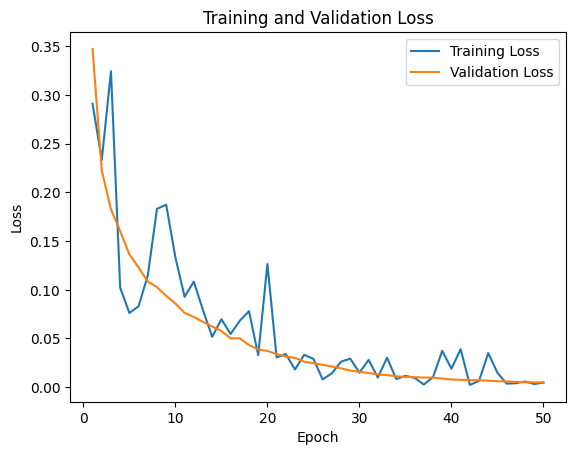

Train Accuracy: 0.9992850333651097
Train F1 Score: 0.9992850442124058
Train Precision: 0.9992860771120219
Train Recall: 0.9992850333651097
Test Accuracy: 0.8849129593810445
Test F1 Score: 0.8848559881043621
Test Precision: 0.8856762633078422
Test Recall: 0.8849129593810445


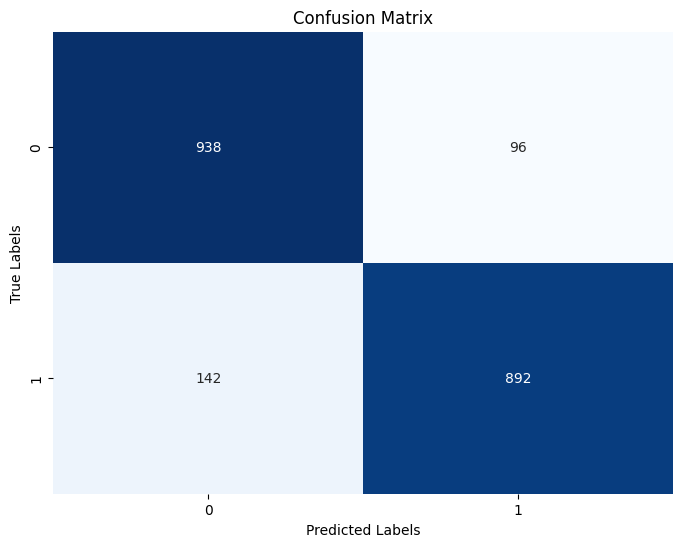

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Load data from CSV
df = pd.read_csv("/content/drive/MyDrive/nlp_dataset/merge.csv")

# Inspect column names
print("Column names in the CSV file:", df.columns)

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise KeyError("CSV file must contain 'text' and 'label' columns")

# Extract 'text' and 'label' columns
texts = df['text'].astype(str).tolist()
labels = df['label'].astype(str).tolist()

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts).toarray().astype(np.float32)
y = np.array(labels).astype(np.uint8)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# Define the MLP model with Dropout
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 100  # Adjust as necessary
output_dim = len(np.unique(y))

model = MLP(input_dim, hidden_dim, output_dim)

# Loss and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training the model with early stopping
num_epochs = 50
batch_size = 64

def train_model_with_early_stopping(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    trials = 0

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size()[0])
        for i in range(0, X_train_tensor.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute training loss
        train_loss = loss.item()
        train_losses.append(train_loss)

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                print("Early stopping")
                break

    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert validation set to PyTorch tensors
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val)

train_model_with_early_stopping(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience=10)

# Evaluating the model
def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)

    acc = accuracy_score(y_tensor.numpy(), preds.numpy())
    f1 = f1_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    prec = precision_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    recall = recall_score(y_tensor.numpy(), preds.numpy(), average='weighted')

    return acc, f1, prec, recall, preds

train_acc, train_f1, train_prec, train_recall, train_preds = evaluate_model(model, X_train_tensor, y_train_tensor)
test_acc, test_f1, test_prec, test_recall, test_preds = evaluate_model(model, X_test_tensor, y_test_tensor)

print("Train Accuracy:", train_acc)
print("Train F1 Score:", train_f1)
print("Train Precision:", train_prec)
print("Train Recall:", train_recall)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_prec)
print("Test Recall:", test_recall)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.show()

plot_confusion_matrix(y_test_tensor.numpy(), test_preds.numpy(), classes=np.unique(y))


Column names in the CSV file: Index(['text', 'label'], dtype='object')
Epoch [1/50], Train Loss: 0.4593, Val Loss: 0.4247
Epoch [2/50], Train Loss: 0.2913, Val Loss: 0.2707
Epoch [3/50], Train Loss: 0.2571, Val Loss: 0.2238
Epoch [4/50], Train Loss: 0.2294, Val Loss: 0.1908
Epoch [5/50], Train Loss: 0.2848, Val Loss: 0.1703
Epoch [6/50], Train Loss: 0.0764, Val Loss: 0.1548
Epoch [7/50], Train Loss: 0.1823, Val Loss: 0.1427
Epoch [8/50], Train Loss: 0.2065, Val Loss: 0.1339
Epoch [9/50], Train Loss: 0.0846, Val Loss: 0.1251
Epoch [10/50], Train Loss: 0.1172, Val Loss: 0.1145
Epoch [11/50], Train Loss: 0.1294, Val Loss: 0.1135
Epoch [12/50], Train Loss: 0.1275, Val Loss: 0.1124
Epoch [13/50], Train Loss: 0.2547, Val Loss: 0.1114
Epoch [14/50], Train Loss: 0.1365, Val Loss: 0.1104
Epoch [15/50], Train Loss: 0.1269, Val Loss: 0.1096
Epoch [16/50], Train Loss: 0.1599, Val Loss: 0.1089
Epoch [17/50], Train Loss: 0.0589, Val Loss: 0.1083
Epoch [18/50], Train Loss: 0.2612, Val Loss: 0.1073
Ep

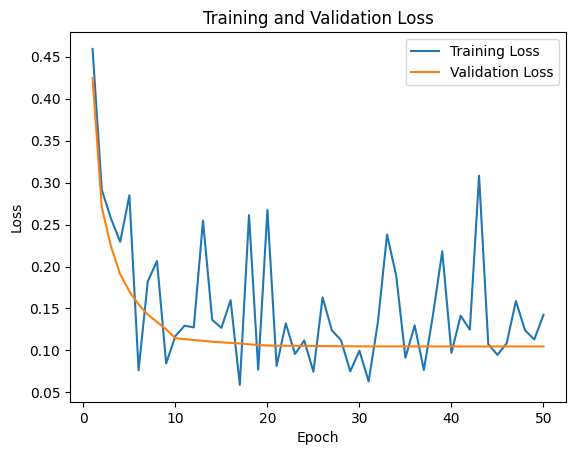

Train Accuracy: 0.9640133460438512
Train F1 Score: 0.9640175061991759
Train Precision: 0.9641715829895101
Train Recall: 0.9640133460438512
Test Accuracy: 0.8979690522243714
Test F1 Score: 0.8979398180146461
Test Precision: 0.8984255537108671
Test Recall: 0.8979690522243714


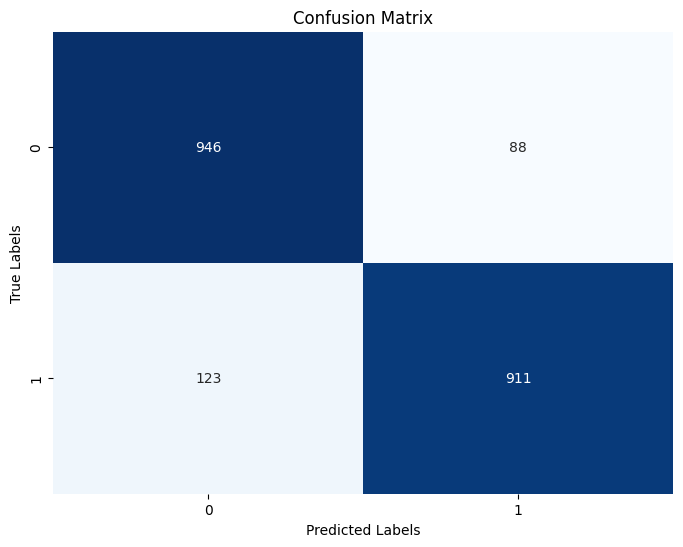

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Load data from CSV
df = pd.read_csv("/content/drive/MyDrive/nlp_dataset/merge.csv")

# Inspect column names
print("Column names in the CSV file:", df.columns)

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise KeyError("CSV file must contain 'text' and 'label' columns")

# Extract 'text' and 'label' columns
texts = df['text'].astype(str).tolist()
labels = df['label'].astype(str).tolist()

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts).toarray().astype(np.float32)
y = np.array(labels).astype(np.uint8)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# Define the MLP model with increased dropout rate
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)  # Increased dropout rate
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 50  # Reduced size of the hidden layer
output_dim = len(np.unique(y))

model = MLP(input_dim, hidden_dim, output_dim)

# Loss and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training the model with early stopping
num_epochs = 50
batch_size = 64

def train_model_with_early_stopping(model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    trials = 0

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size()[0])
        for i in range(0, X_train_tensor.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Step the scheduler
        scheduler.step()

        # Compute training loss
        train_loss = loss.item()
        train_losses.append(train_loss)

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                print("Early stopping")
                break

    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert validation set to PyTorch tensors
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val)

train_model_with_early_stopping(model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience=15)

# Evaluating the model
def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)

    acc = accuracy_score(y_tensor.numpy(), preds.numpy())
    f1 = f1_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    prec = precision_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    recall = recall_score(y_tensor.numpy(), preds.numpy(), average='weighted')

    return acc, f1, prec, recall, preds

train_acc, train_f1, train_prec, train_recall, train_preds = evaluate_model(model, X_train_tensor, y_train_tensor)
test_acc, test_f1, test_prec, test_recall, test_preds = evaluate_model(model, X_test_tensor, y_test_tensor)

print("Train Accuracy:", train_acc)
print("Train F1 Score:", train_f1)
print("Train Precision:", train_prec)
print("Train Recall:", train_recall)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_prec)
print("Test Recall:", test_recall)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.show()

plot_confusion_matrix(y_test_tensor.numpy(), test_preds.numpy(), classes=np.unique(y))


Column names in the CSV file: Index(['text', 'label'], dtype='object')
Epoch [1/50], Train Loss: 0.5081, Val Loss: 0.4210
Epoch [2/50], Train Loss: 0.2528, Val Loss: 0.2717
Epoch [3/50], Train Loss: 0.3429, Val Loss: 0.2182
Epoch [4/50], Train Loss: 0.1672, Val Loss: 0.1910
Epoch [5/50], Train Loss: 0.1099, Val Loss: 0.1720
Epoch [6/50], Train Loss: 0.2325, Val Loss: 0.1528
Epoch [7/50], Train Loss: 0.2009, Val Loss: 0.1406
Epoch [8/50], Train Loss: 0.3264, Val Loss: 0.1300
Epoch [9/50], Train Loss: 0.0766, Val Loss: 0.1200
Epoch [10/50], Train Loss: 0.1414, Val Loss: 0.1133
Epoch [11/50], Train Loss: 0.1627, Val Loss: 0.1118
Epoch [12/50], Train Loss: 0.1239, Val Loss: 0.1102
Epoch [13/50], Train Loss: 0.0564, Val Loss: 0.1093
Epoch [14/50], Train Loss: 0.1045, Val Loss: 0.1082
Epoch [15/50], Train Loss: 0.1206, Val Loss: 0.1073
Epoch [16/50], Train Loss: 0.1739, Val Loss: 0.1065
Epoch [17/50], Train Loss: 0.1501, Val Loss: 0.1054
Epoch [18/50], Train Loss: 0.1258, Val Loss: 0.1047
Ep

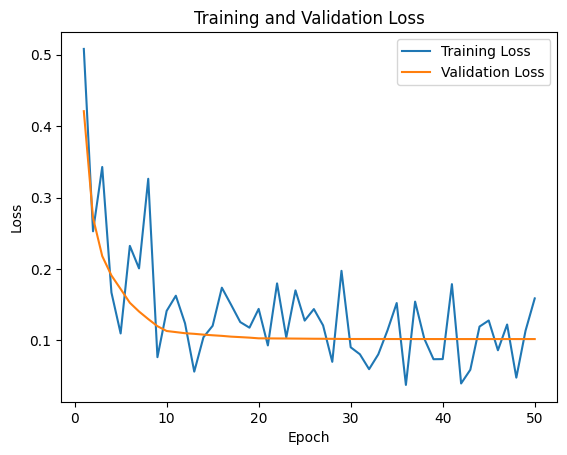

Train Accuracy: 0.9647283126787417
Train F1 Score: 0.9647325442041047
Train Precision: 0.964989266404209
Train Recall: 0.9647283126787417
Test Accuracy: 0.9003868471953579
Test F1 Score: 0.9003375359222627
Test Precision: 0.9011808367071524
Test Recall: 0.9003868471953579


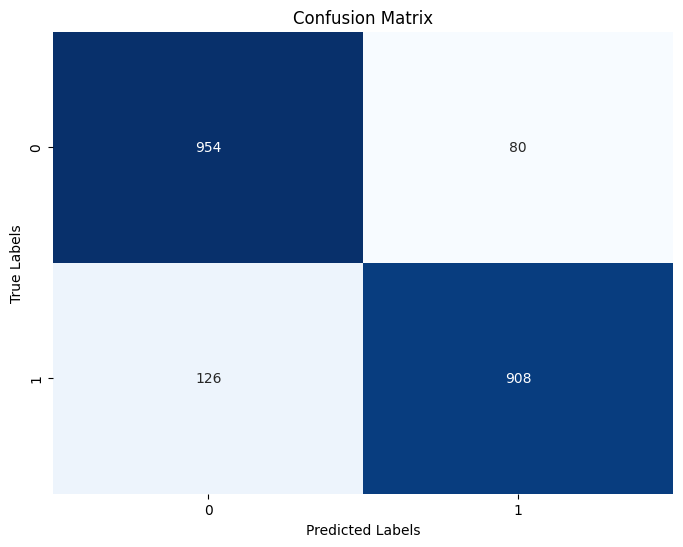

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Load data from CSV
df = pd.read_csv("/content/drive/MyDrive/nlp_dataset/merge.csv")

# Inspect column names
print("Column names in the CSV file:", df.columns)

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise KeyError("CSV file must contain 'text' and 'label' columns")

# Extract 'text' and 'label' columns
texts = df['text'].astype(str).tolist()
labels = df['label'].astype(str).tolist()

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts).toarray().astype(np.float32)
y = np.array(labels).astype(np.uint8)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# Define the MLP model with increased dropout rate
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)  # Increased dropout rate
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 50  # Reduced size of the hidden layer
output_dim = len(np.unique(y))

model = MLP(input_dim, hidden_dim, output_dim)

# Loss and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training the model with early stopping
num_epochs = 50
batch_size = 64

def train_model_with_early_stopping(model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    trials = 0

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size()[0])
        for i in range(0, X_train_tensor.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Step the scheduler
        scheduler.step()

        # Compute training loss
        train_loss = loss.item()
        train_losses.append(train_loss)

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                print("Early stopping")
                break

    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert validation set to PyTorch tensors
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val)

train_model_with_early_stopping(model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience=15)

# Evaluating the model
def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)

    acc = accuracy_score(y_tensor.numpy(), preds.numpy())
    f1 = f1_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    prec = precision_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    recall = recall_score(y_tensor.numpy(), preds.numpy(), average='weighted')

    return acc, f1, prec, recall, preds

train_acc, train_f1, train_prec, train_recall, train_preds = evaluate_model(model, X_train_tensor, y_train_tensor)
test_acc, test_f1, test_prec, test_recall, test_preds = evaluate_model(model, X_test_tensor, y_test_tensor)

print("Train Accuracy:", train_acc)
print("Train F1 Score:", train_f1)
print("Train Precision:", train_prec)
print("Train Recall:", train_recall)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_prec)
print("Test Recall:", test_recall)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.show()

plot_confusion_matrix(y_test_tensor.numpy(), test_preds.numpy(), classes=np.unique(y))


Column names in the CSV file: Index(['text', 'label'], dtype='object')
Epoch [1/50], Train Loss: 0.4157, Val Loss: 0.4036
Epoch [2/50], Train Loss: 0.2806, Val Loss: 0.2540
Epoch [3/50], Train Loss: 0.2677, Val Loss: 0.2022
Epoch [4/50], Train Loss: 0.1170, Val Loss: 0.1724
Epoch [5/50], Train Loss: 0.1825, Val Loss: 0.1485
Epoch [6/50], Train Loss: 0.1281, Val Loss: 0.1342
Epoch [7/50], Train Loss: 0.0659, Val Loss: 0.1195
Epoch [8/50], Train Loss: 0.1456, Val Loss: 0.1073
Epoch [9/50], Train Loss: 0.2447, Val Loss: 0.0945
Epoch [10/50], Train Loss: 0.0437, Val Loss: 0.0851
Epoch [11/50], Train Loss: 0.0902, Val Loss: 0.0835
Epoch [12/50], Train Loss: 0.0737, Val Loss: 0.0822
Epoch [13/50], Train Loss: 0.1444, Val Loss: 0.0812
Epoch [14/50], Train Loss: 0.0882, Val Loss: 0.0801
Epoch [15/50], Train Loss: 0.1937, Val Loss: 0.0792
Epoch [16/50], Train Loss: 0.1627, Val Loss: 0.0781
Epoch [17/50], Train Loss: 0.0953, Val Loss: 0.0770
Epoch [18/50], Train Loss: 0.1274, Val Loss: 0.0763
Ep

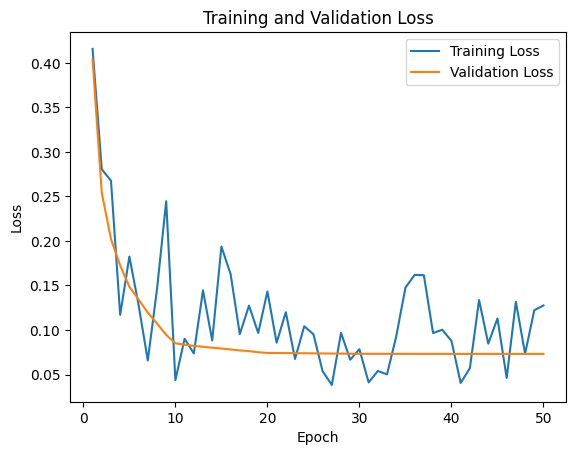

Train Accuracy: 0.9768318965517241
Train F1 Score: 0.9768188078608985
Train Precision: 0.9769456791603126
Train Recall: 0.9768318965517241
Test Accuracy: 0.911410864017499
Test F1 Score: 0.9113070069029966
Test Precision: 0.9116542218949136
Test Recall: 0.911410864017499


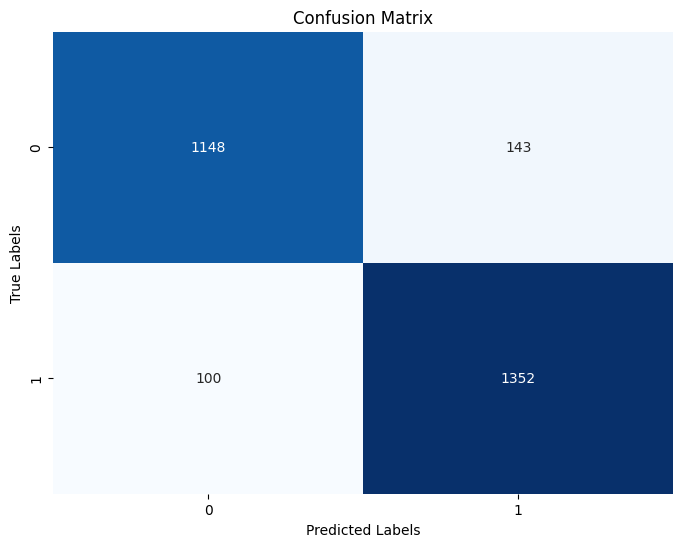

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Load data from CSV
df = data_merge_ma

# Inspect column names
print("Column names in the CSV file:", df.columns)

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Check if 'text' and 'label' columns exist
if 'text' not in df.columns or 'label' not in df.columns:
    raise KeyError("CSV file must contain 'text' and 'label' columns")

# Extract 'text' and 'label' columns
texts = df['text'].astype(str).tolist()
labels = df['label'].astype(str).tolist()

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts).toarray().astype(np.float32)
y = np.array(labels).astype(np.uint8)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# Define the MLP model with increased dropout rate
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)  # Increased dropout rate
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 50  # Reduced size of the hidden layer
output_dim = len(np.unique(y))

model = MLP(input_dim, hidden_dim, output_dim)

# Loss and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training the model with early stopping
num_epochs = 50
batch_size = 64

def train_model_with_early_stopping(model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    trials = 0

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size()[0])
        for i in range(0, X_train_tensor.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Step the scheduler
        scheduler.step()

        # Compute training loss
        train_loss = loss.item()
        train_losses.append(train_loss)

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                print("Early stopping")
                break

    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert validation set to PyTorch tensors
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val)

train_model_with_early_stopping(model, criterion, optimizer, scheduler, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, batch_size, patience=15)

# Evaluating the model
def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)

    acc = accuracy_score(y_tensor.numpy(), preds.numpy())
    f1 = f1_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    prec = precision_score(y_tensor.numpy(), preds.numpy(), average='weighted')
    recall = recall_score(y_tensor.numpy(), preds.numpy(), average='weighted')

    return acc, f1, prec, recall, preds

train_acc, train_f1, train_prec, train_recall, train_preds = evaluate_model(model, X_train_tensor, y_train_tensor)
test_acc, test_f1, test_prec, test_recall, test_preds = evaluate_model(model, X_test_tensor, y_test_tensor)

print("Train Accuracy:", train_acc)
print("Train F1 Score:", train_f1)
print("Train Precision:", train_prec)
print("Train Recall:", train_recall)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_prec)
print("Test Recall:", test_recall)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes)
    plt.show()

plot_confusion_matrix(y_test_tensor.numpy(), test_preds.numpy(), classes=np.unique(y))
